## 🧩 Ensemble Learning

In this notebook, I would create a custom ensemble that uses a RandomForest model, a LightGBM model, and a simple neural network as a meta-learner.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

From the hyperparameter optimization process, I saved optimal parameters for the models, and I would use those parameters to work with the models for building the ensemble. These are the parameters from the process:

**RandomForest Parameters:**

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 419, 'n_jobs': None, 'oob_score': False, 'random_state': 33, 'verbose': 0, 'warm_start': False}

**LightGBM Parameters:**

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8041790107956245, 'importance_type': 'split', 'learning_rate': 0.16247492555874504, 'max_depth': 14, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 448, 'n_jobs': None, 'num_leaves': 75, 'objective': None, 'random_state': 33, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9365271900465331, 'subsample_for_bin': 200000, 'subsample_freq': 0}

In [3]:
# Loading the datasets and the model parameters
# Datasets
train = pd.read_csv("../dataset/wine-train-balanced.csv")
test = pd.read_csv("../dataset/wine-test.csv")

# Combining both datasets
df = pd.concat([train, test], ignore_index=True)
print("Dataset shape:", df.shape)

with open("../data/rf_optimized_params.json", "r") as file:
    rf_params = json.load(file)

with open("../data/lgbm_optimized_params.json", "r") as file:
    lgbm_params = json.load(file)

print(rf_params)
print(lgbm_params)

Dataset shape: (7962, 13)
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 419, 'n_jobs': None, 'oob_score': False, 'random_state': 33, 'verbose': 0, 'warm_start': False}
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8041790107956245, 'importance_type': 'split', 'learning_rate': 0.16247492555874504, 'max_depth': 14, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 448, 'n_jobs': None, 'num_leaves': 75, 'objective': None, 'random_state': 33, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9365271900465331, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [4]:
df.sample(7)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,wine_type,quality
5070,6.040785,0.333353,0.270000,2.958611,0.035000,15.407854,99.111782,0.991368,3.311178,0.597492,11.588822,1,1
7404,7.800000,0.590000,0.180000,2.300000,0.076000,17.000000,54.000000,0.997500,3.430000,0.590000,10.000000,0,0
1107,5.800000,0.280000,0.300000,1.500000,0.026000,31.000000,114.000000,0.989520,3.320000,0.600000,12.500000,1,1
5563,6.216838,0.303790,0.235842,2.128424,0.033168,17.415808,136.810505,0.989943,3.362474,0.712106,13.311586,1,1
6736,7.368396,0.386132,0.313160,1.980659,0.061561,4.683955,12.438682,0.995411,3.347877,0.886699,10.841978,0,1
4263,7.588439,0.202362,0.331808,14.188439,0.051643,45.000000,158.296442,0.998989,3.051255,0.525375,8.717589,1,1
7030,6.900000,0.190000,0.400000,1.400000,0.036000,14.000000,55.000000,0.990900,3.080000,0.680000,11.500000,1,1


In [5]:
# Separating dataset into features (X) and labels (y)
X = df.drop(["quality"], axis=1)
y = df["quality"]

print(X.shape, y.shape)

(7962, 12) (7962,)


Although the base models (RandomForest and LightGBM) are not affected from the scale of the data, I would scale the features as it would help the neural network (meta-learner)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# I'll save the scaler for later use
with open("../artifacts/wine_ds_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

In [7]:
# Defining the base models with optimized parameters
rf_clf = RandomForestClassifier(**rf_params)
lgbm_clf = LGBMClassifier(verbosity=-1, **lgbm_params)

I would create out-of-fold predictions by performing cross-validation on the base models to get probability estimates of the positive class. The output would be fed as features to the meta-learner. This is to avoid data leakage when training the meta-learner.

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# Out-of-fold predictions for RandomForest model
rf_oof = cross_val_predict(
    rf_clf, X_scaled, y, cv=cv, method="predict_proba"
)[:, 1]

# Out-of-fold predictions for LightGBM model
lgbm_oof = cross_val_predict(
    lgbm_clf, X_scaled, y, cv=cv, method="predict_proba"
)[:, 1]

# Stacking the predictions from both models as features for the meta-learner
stack_train = np.column_stack([rf_oof, lgbm_oof])

In [9]:
print(stack_train.shape)
stack_train[:5]

(7962, 2)


array([[7.51692824e-02, 2.89278498e-06],
       [8.24216026e-01, 9.97829335e-01],
       [2.15138084e-02, 6.84858829e-10],
       [1.95928256e-01, 1.83999787e-05],
       [7.77507241e-01, 8.04223047e-01]])

### Meta-Learner

The meta learner is a simple neural network (deep learning model). The inputs to the neural network are the base-model's probabilities and not raw features. 

In [10]:
# Helper to create meta-learner neural network
def build_meta_nn(input_dim: int = 2):
    # Define the model architecure
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [11]:
# Creating the meta-learner
meta_nn = build_meta_nn(input_dim=stack_train.shape[1])
meta_nn.summary()

2025-09-19 12:41:02.975862: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Trainign the model
meta_history = meta_nn.fit(
    stack_train, y, epochs=10, batch_size=32, validation_split=0.15
)

Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5793 - loss: 0.6647 - val_accuracy: 0.8368 - val_loss: 0.6626
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.9047 - loss: 0.5501 - val_accuracy: 0.8418 - val_loss: 0.5974
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.9073 - loss: 0.4576 - val_accuracy: 0.8435 - val_loss: 0.5316
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.9109 - loss: 0.3790 - val_accuracy: 0.8502 - val_loss: 0.4608
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.9125 - loss: 0.3185 - val_accuracy: 0.8502 - val_loss: 0.4183
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.9122 - loss: 0.2829 - val_accuracy: 0.8510 - val_loss: 0.4018
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9127 - loss: 0.2652 - val_accuracy: 0.8510 - val_loss: 0.3993
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.9131 - loss: 0.2567 - va

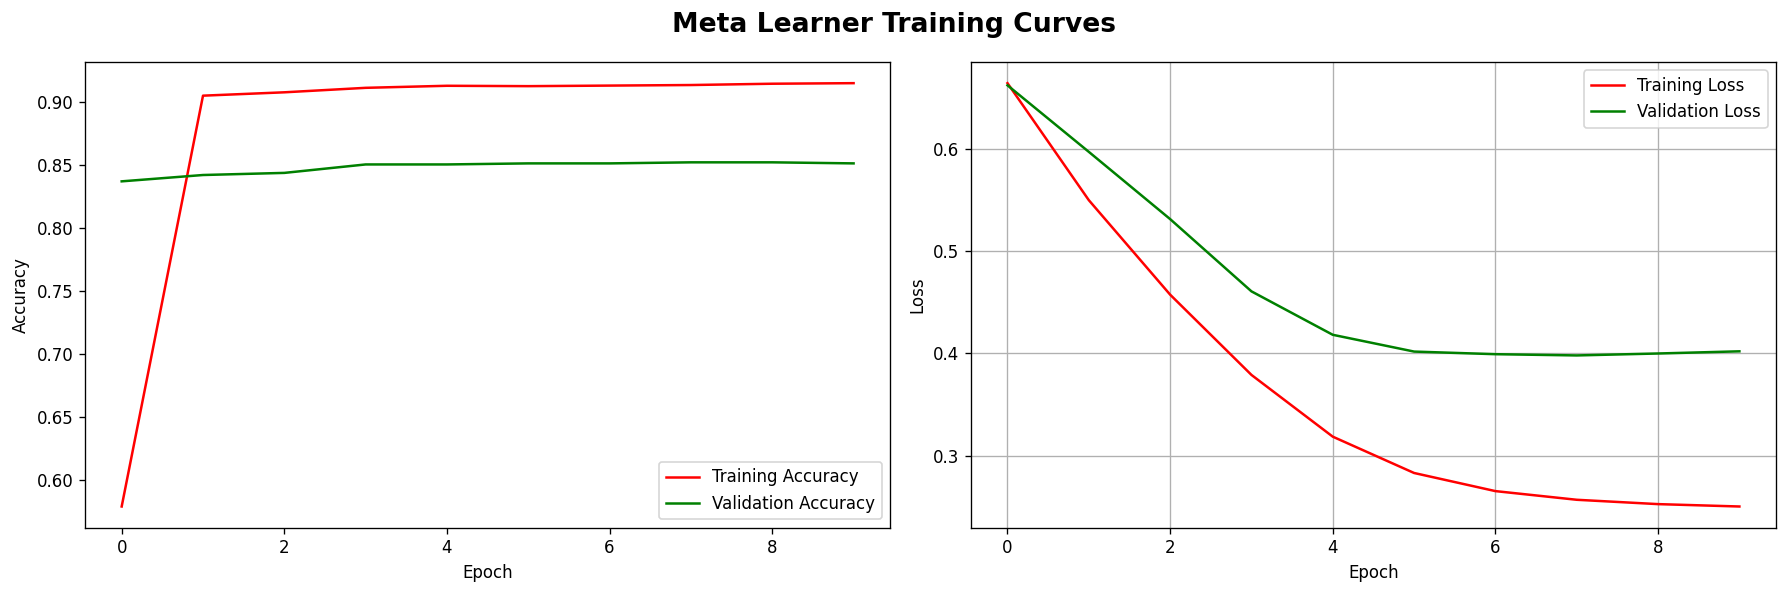

In [ ]:
history = meta_history.history

plt.figure(figsize=(15, 5), dpi=120)

# ----- Plot training and validation accuracy values ----- #
plt.subplot(1, 2, 1)
plt.plot(history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history["val_accuracy"], label="Validation Accuracy", c="green")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")

# ----- Plot training and validation loss values ----- #
plt.subplot(1, 2, 2)
plt.plot(history["loss"], label="Training Loss", c="red")
plt.plot(history["val_loss"], label="Validation Loss", c="green")

plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.suptitle("Meta Learner Training Curves", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.grid(True)
plt.savefig("../img/meta-learner-training-curves.png")
plt.show()

In [ ]:
# Helper to make predictions with the full ensemble
def ensemble_predict(x, ptype: str = "proba"):
    # Predict probabilities with base models
    base_preds = np.column_stack([
        rf_clf.predict_proba(x)[:, 1],
        lgbm_clf.predict_proba(x)[:, 1]
    ])

    final_probs = meta_nn.predict(base_preds)

    if ptype == "proba":
        return final_probs

    return (final_probs > 0.5).astype(int)

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
Test Accuracy: 0.8871


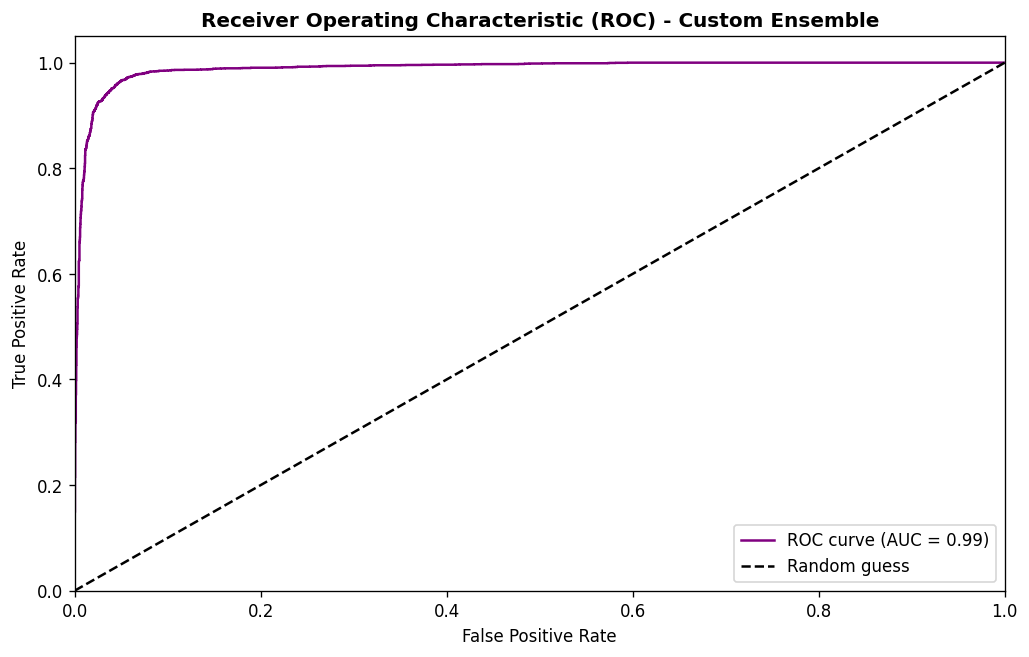

In [39]:
# Visualizing ROC-AUC for the ensemble pipeline
# Array of predicted probabilities for the positive class
preds = ensemble_predict(X_scaled)

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y, preds)

# Compute the Area Under the Curve (AUC)
auc_score = roc_auc_score(y, preds)

print("Test Accuracy: {:.4f}".format(accuracy_score(y, ensemble_predict(X_scaled, ptype="binary"))))

# Plot
plt.figure(figsize=(10, 6), dpi=120)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})", color="purple")
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - Custom Ensemble", fontweight="bold")
plt.legend(loc="lower right")

plt.savefig("../img/ensemble_roc_auc.png")
plt.show()

In [18]:
# Save the meta learner model
tf.keras.models.save_model(meta_nn, "../artifacts/meta-learner.keras")